In [1]:
import sys
import os

def get_FGCE_Directory():
    """Get the path of the 'FGCE-Feasible-Group-Counterfactual-Explanations-for-Auditing-Fairness' directory."""
    current_dir = os.getcwd()
    target_dir = 'FGCE-Feasible-Group-Counterfactual-Explanations-for-Auditing-Fairness'
    
    while os.path.basename(current_dir) != target_dir:
        current_dir = os.path.dirname(current_dir)
        if current_dir == os.path.dirname(current_dir):
            return None
        
    return current_dir

def get_system_slash():
    """Get the system-specific directory separator."""
    return os.sep

FGCE_DIR = get_FGCE_Directory()
sys.path.append(FGCE_DIR)
sep = get_system_slash()
sys.path.append(FGCE_DIR + get_system_slash() + 'src')
from main import *

2024-05-21 00:05:56.348334: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-21 00:05:56.348359: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-21 00:05:56.349178: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-21 00:05:56.353397: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-21 00:05:56.892079: W tensorflow/compiler/tf2

# Decide Epsilon parameter

Loading classifier from file ...
Calculating bandwidth for Student...
Bandwidth: 0.09317241379310345
Fitting kernel...
Loading distances from file ...
Max distance in the dataset: 6.557438524302
Max possible distance considered in graph: 0.09375
{'strongly_connected_components': 648, 'weakly_connected_components': 648, 'Percentage_of_connected_nodes': 0.30816640986132515, 'Density': 0.0004755654473168597}

Calculating bandwidth for Student...
Bandwidth: 0.09317241379310345
Fitting kernel...
Loading distances from file ...
Max distance in the dataset: 6.557438524302
Max possible distance considered in graph: 0.25
{'strongly_connected_components': 647, 'weakly_connected_components': 646, 'Percentage_of_connected_nodes': 0.9244992295839755, 'Density': 0.0011889136182921495}

Calculating bandwidth for Student...
Bandwidth: 0.09317241379310345
Fitting kernel...
Loading distances from file ...
Max distance in the dataset: 6.557438524302
Max possible distance considered in graph: 0.8897614985

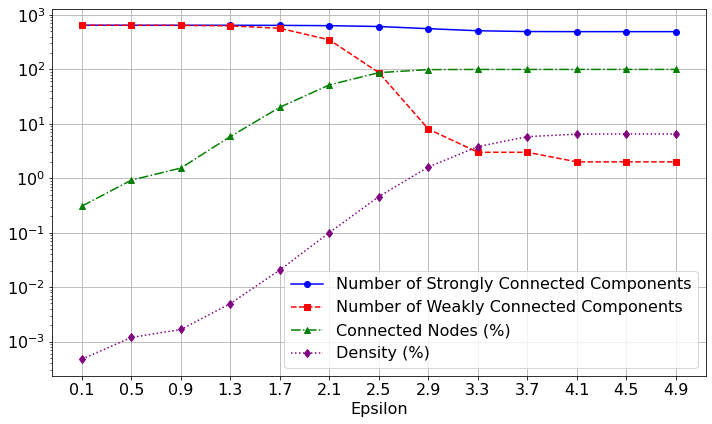

In [8]:
from main import *
from utils import *

dataset_results = {}

tp = 0.6
skip_bandwith_calculation=True
datasetName = 'Student'

data, FEATURE_COLUMNS, TARGET_COLUMNS, numeric_columns, categorical_columns, min_max_scaler, data_df_copy, continuous_featues = load_dataset(datasetName=datasetName)
TEST_SIZE = 0.3

X = data[FEATURE_COLUMNS]
y = data[TARGET_COLUMNS]

data_np = data.to_numpy()
attr_col_mapping = {col: i for i, col in enumerate(data.columns)}

X = data_np[:, [attr_col_mapping[col] for col in FEATURE_COLUMNS]]
if isinstance(TARGET_COLUMNS, str):
    y = data_np[:, attr_col_mapping[TARGET_COLUMNS]]
else:
    y = data_np[:, [attr_col_mapping[col] for col in TARGET_COLUMNS]]

X_train, X_test, y_train, y_test = train_test_split(
    data[FEATURE_COLUMNS],
    data[TARGET_COLUMNS],
    test_size=TEST_SIZE,
    random_state=utils.random_seed,
    shuffle=True
)

index_mapping_test = {new_index: original_index for new_index, original_index in enumerate(X_test.index)}
index_mapping_train = {new_index: original_index for new_index, original_index in enumerate(X_train.index)}

X_train_np = X_train.to_numpy()
X_test_np = X_test.to_numpy()
y_train_np = y_train.to_numpy().reshape(-1, 1)
y_test_np = y_test.to_numpy().reshape(-1, 1)

data_train = np.concatenate((X_train_np, y_train_np), axis=1)
data_test = np.concatenate((X_test_np, y_test_np), axis=1)

index_mapping = {new_index: original_index for new_index, original_index in enumerate(X_test.index)}

if "LR_classifier_face_data.pk" in os.listdir(f"{FGCE_DIR}{sep}tmp{sep}{datasetName}{sep}"):
        print("Loading classifier from file ...")
        clf = pk.load(open(f"{FGCE_DIR}{sep}tmp{sep}{datasetName}{sep}LR_classifier_face_data.pk", "rb"))
else:
    clf = LogisticRegression(random_state=utils.random_seed)
    clf.fit(X_train, y_train)

    print("Training accuracy:", clf.score(X_train, y_train))
    print("Testing accuracy:", clf.score(X_test, y_test))

    if not os.path.exists(f"{FGCE_DIR}{sep}tmp{sep}{datasetName}{sep}"):
        os.makedirs(f"{FGCE_DIR}{sep}tmp{sep}{datasetName}{sep}")

    pk.dump(clf, open(f"{FGCE_DIR}{sep}tmp{sep}{datasetName}{sep}LR_classifier_face_data.pk", 'wb'))

FN, negative_points, positive_points, FP = utils.get_FN_Negatives_Positives(data_test, clf, tp, attr_col_mapping, FEATURE_COLUMNS, TARGET_COLUMNS, index_mapping)

group_identifier = "sex"
group_identifier_value = None

results = {}
start=0.1
step=0.4
max_distances_in_the_dataset = np.sqrt(len(FEATURE_COLUMNS))

for e in np.arange(start, max_distances_in_the_dataset-1.5, step):
    e = round(e, 2)
    if os.path.exists(f"{FGCE_DIR}{sep}tmp{sep}{datasetName}{sep}Distances{sep}Distances_{e}.pkl") and os.path.exists(f"{FGCE_DIR}{sep}tmp{sep}{datasetName}{sep}Graphs{sep}Graph_{e}.pkl"):
        graph = pk.load(open(f"{FGCE_DIR}{sep}tmp{sep}{datasetName}{sep}Graphs{sep}Graph_{e}.pkl", "rb"))
        kernel = Kernel_obj(datasetName, X, skip_bandwith_calculation=skip_bandwith_calculation, bandwith_approch="optimal")
        kernel.fitKernel(X)
        fgce = FGCE(data_np, X, kernel, FEATURE_COLUMNS, TARGET_COLUMNS, e, clf)
        fgce.set_graph(graph)

        print("Loading distances from file ...")
        distances = pk.load(open(f"{FGCE_DIR}{sep}tmp{sep}{datasetName}{sep}Distances{sep}Distances_{e}.pkl", "rb"))

    else:
        kernel = Kernel_obj(datasetName, X, skip_bandwith_calculation=skip_bandwith_calculation, bandwith_approch="optimal")
        kernel.fitKernel(X)
        fgce = FGCE(data_np, X, kernel, FEATURE_COLUMNS, TARGET_COLUMNS, e, clf)
        feasibility_constraints = utils.getFeasibilityConstraints(FEATURE_COLUMNS, dataset_name=datasetName)

        start_time = time.time()
        dng_obj = GraphBuilder(feasibility_constraints, FEATURE_COLUMNS, X, kernel, exclude_columns=True)
        distances, graph, densities = dng_obj.compute_pairwise_distances_within_subgroups_and_graph(datasetName, data[FEATURE_COLUMNS], e, feasibility_constraints, None)
        end_time = time.time()
        execution_time = end_time - start_time
        print("Distances and graph initialization: ", execution_time, " seconds")

        if not os.path.exists(f"{FGCE_DIR}{sep}tmp{sep}{datasetName}{sep}Graphs{sep}"):
            os.makedirs(f"{FGCE_DIR}{sep}tmp{sep}{datasetName}{sep}Graphs{sep}")
        if not os.path.exists(f"{FGCE_DIR}{sep}tmp{sep}{datasetName}{sep}Distances{sep}"):
            os.makedirs(f"{FGCE_DIR}{sep}tmp{sep}{datasetName}{sep}Distances")
        if not os.path.exists(f"{FGCE_DIR}{sep}tmp{sep}{datasetName}{sep}Densities{sep}"):
            os.makedirs(f"{FGCE_DIR}{sep}tmp{sep}{datasetName}{sep}Densities")

        pk.dump(graph, open(f"{FGCE_DIR}{sep}tmp{sep}{datasetName}{sep}Graphs{sep}Graph_{e}.pkl", "wb"))
        pk.dump(distances, open(f"{FGCE_DIR}{sep}tmp{sep}{datasetName}{sep}Distances{sep}Distances_{e}.pkl", "wb"))
        pk.dump(densities, open(f"{FGCE_DIR}{sep}tmp{sep}{datasetName}{sep}Densities{sep}Densities_{e}.pkl", "wb"))

    max_distances_in_the_dataset = np.sqrt(len(FEATURE_COLUMNS))
    print(f"Max distance in the dataset: {max_distances_in_the_dataset}")
    print(f"Max possible distance considered in graph: {np.max(distances)}")

    strongly_connected_components = list(nx.strongly_connected_components(graph))
    weakly_connected_components = list(nx.weakly_connected_components(graph))

    connected_nodes = sum(1 for node, degree in graph.degree() if degree > 0)

    graph_density = nx.density(graph)

    d = {"strongly_connected_components": len(strongly_connected_components), "weakly_connected_components": len(weakly_connected_components),
        "Percentage_of_connected_nodes": (connected_nodes/len(X))*100, "Density": graph_density * 100}
    results[e] = d
    print(  d)
    print()

import matplotlib.pyplot as plt

epsilons = list(results.keys())
strongly_connected_components = [results[k]["strongly_connected_components"] for k in epsilons]
weakly_connected_components = [results[k]["weakly_connected_components"] for k in epsilons]
node_connectivity = [results[k]["Percentage_of_connected_nodes"] for k in epsilons]
edge_connectivity = [results[k]["Density"] for k in epsilons]

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(epsilons, strongly_connected_components, marker='o', linestyle='-', color='b', label="Number of Strongly Connected Components")
ax.plot(epsilons, weakly_connected_components, marker='s', linestyle='--', color='r', label="Number of Weakly Connected Components")
ax.plot(epsilons, node_connectivity, marker='^', linestyle='-.', color='g', label="Connected Nodes (%)")
ax.plot(epsilons, edge_connectivity, marker='d', linestyle=':', color='purple', label="Density (%)")
ax.set_xlabel("Epsilon", fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_yscale('log')
ax.set_xticks(epsilons)
ax.legend(fontsize=16)
plt.grid(True)
plt.tight_layout()
fig.savefig(f"{FGCE_DIR}{sep}tmp{sep}{datasetName}{sep}figs{sep}{datasetName}_connectivity_plot.pdf")
plt.show()

In [2]:
def filter_subdict(experiment, allowed_subkeys):
    result = {}
    for key, value in experiment.items():
        if isinstance(value, dict):
            filtered_subdict = {}
            for subkey, subvalue in value.items():
                if subkey in allowed_subkeys:
                    filtered_subdict[subkey] = subvalue
            result[key] = filtered_subdict
        else:
            result[key] = value
    return result


allowed_subkeys = ["Coverage", "Avg. distance", "Avg. path cost"]

## Stable Epsilon, k. d Parameter

In [ ]:
results = {}

import numpy as np

for max_d in np.arange(0.1, 5, 0.4):
    results[max_d] = (filter_subdict(main_cost_constrained_GCFEs(epsilon=3, tp=0.6, td=0.001, datasetName='Student', group_identifier='sex',
                            skip_model_training=True, skip_gcfe_calculation=False, skip_graph_creation=True, skip_distance_calculation=True,
                            max_d = max_d, cost_function = "max_vector_distance", k=3, k_selection_method="greedy_accross_all_ccs")[0], allowed_subkeys))

Saturation point for group 0: 3.7

Saturation point for group 1: 4.1


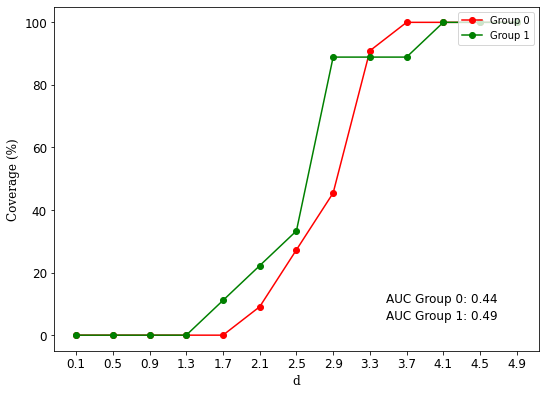

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import auc

saturation_point_g0 = 0
saturation_point_g1 = 0
coverage_till_now_g0 = 0
coverage_till_now_g1 = 0

group_coverages = {0.0: [], 1.0: []}
for d in results:
    cov0 = results[d][0.0]['Coverage']
    if cov0 > coverage_till_now_g0:
        coverage_till_now_g0 = cov0
        saturation_point_g0 = d
    
    cov1 = results[d][1.0]['Coverage']
    if cov1 > coverage_till_now_g1:
        coverage_till_now_g1 = cov1
        saturation_point_g1 = d

    group_coverages[0.0].append(cov0)
    group_coverages[1.0].append(cov1)

print(f"Saturation point for group 0: {saturation_point_g0}")
print(f"\nSaturation point for group 1: {saturation_point_g1}")

group0_coverages = np.array(group_coverages[0.0])
group1_coverages = np.array(group_coverages[1.0])

x = list(np.round(np.arange(0.1, 5, 0.4), 2))
max_auc = auc(x, [100]*len(x))

auc_group0 = auc(x, group0_coverages) / max_auc
auc_group1 = auc(x, group1_coverages) / max_auc

plt.plot(x, group_coverages[0.0], 'o-', color='red', label='Group 0')
plt.plot(x, group_coverages[1.0], 'o-', color='green', label='Group 1')
plt.text(0.8, 0.15, f'AUC Group 0: {auc_group0:.2f}', horizontalalignment='center', verticalalignment='center',  fontsize=12,transform=plt.gca().transAxes)
plt.text(0.8, 0.1, f'AUC Group 1: {auc_group1:.2f}', horizontalalignment='center', verticalalignment='center', fontsize=12, transform=plt.gca().transAxes)
plt.ylabel('Coverage (%)', fontsize=12, fontfamily='serif')
plt.xticks(x)
plt.xlabel('d', fontsize=12, fontfamily='serif')
plt.xticks(x)
plt.tick_params(axis='both', labelsize=12)
plt.legend(loc='upper right') 
plt.tight_layout()
fig_size = (8, 6) 
plt.gcf().set_size_inches(fig_size)
if not os.path.exists(f"{FGCE_DIR}{sep}tmp{sep}Adult{sep}figs{sep}"):
    os.makedirs(f"{FGCE_DIR}{sep}tmp{sep}Adult{sep}figs{sep}")
plt.savefig(f"{FGCE_DIR}{sep}tmp{sep}Adult{sep}figs{sep}max_vector_distance_as_cost_function_stable_k.pdf")
plt.show()

In [5]:
3.99 * (70/100)

2.793

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import auc

auc_matrix = {}
saturation_points = {}
for cfes in range(1, 11):
    saturation_point_g0 = 0
    saturation_point_g1 = 0
    coverage_till_now_g0 = 0
    coverage_till_now_g1 = 0

    auc_matrix[cfes] = {}
    results = {}
    for max_d in np.arange(2.79, 6.5, 0.3):
        results[max_d] = (filter_subdict(main_cost_constrained_GCFEs(epsilon=3, tp=0.6, td=0.001, datasetName='Student', group_identifier='sex',
                                skip_model_training=True, skip_gcfe_calculation=False, skip_graph_creation=True,
                                max_d = max_d, cost_function = "max_vector_distance", k=cfes, k_selection_method="greedy_accross_all_ccs")[0], allowed_subkeys))

    group_coverages = {0.0: [], 1.0: []}
    for d in results:
        cov0 = results[d][0.0]['Coverage'] 
        if cov0 > coverage_till_now_g0:
            coverage_till_now_g0 = cov0
            saturation_point_g0 = d
        
        cov1 = results[d][1.0]['Coverage']
        if cov1 > coverage_till_now_g1:
            coverage_till_now_g1 = cov1
            saturation_point_g1 = d

        group_coverages[0.0].append(cov0)
        group_coverages[1.0].append(cov1)
    
    saturation_points[cfes] = {0.0: saturation_point_g0, 1.0: saturation_point_g1}

    x = list(np.arange(2.79, 6.5, 0.3))
    max_auc = auc(x, [100]*len(x))

    group0_coverages = np.array(group_coverages[0.0])
    group1_coverages = np.array(group_coverages[1.0]) 

    group0_coverages = np.round(auc(x, group0_coverages) / max_auc, 2)
    group1_coverages = np.round(auc(x, group1_coverages) / max_auc, 2)

    auc_matrix[cfes] = {0.0: group0_coverages, 1.0: group1_coverages}

In [7]:
saturation_points

{1: {0.0: 3.9899999999999993, 1.0: 3.9899999999999993},
 2: {0.0: 3.9899999999999993, 1.0: 3.9899999999999993},
 3: {0.0: 3.6899999999999995, 1.0: 3.9899999999999993},
 4: {0.0: 3.3899999999999997, 1.0: 3.9899999999999993},
 5: {0.0: 3.3899999999999997, 1.0: 3.9899999999999993},
 6: {0.0: 3.3899999999999997, 1.0: 3.9899999999999993},
 7: {0.0: 3.3899999999999997, 1.0: 3.9899999999999993},
 8: {0.0: 3.3899999999999997, 1.0: 3.9899999999999993},
 9: {0.0: 3.3899999999999997, 1.0: 3.9899999999999993},
 10: {0.0: 3.3899999999999997, 1.0: 3.9899999999999993}}

In [8]:
auc_matrix

{1: {0.0: 0.7, 1.0: 0.94},
 2: {0.0: 0.89, 1.0: 0.96},
 3: {0.0: 0.93, 1.0: 0.96},
 4: {0.0: 0.95, 1.0: 0.97},
 5: {0.0: 0.95, 1.0: 0.97},
 6: {0.0: 0.96, 1.0: 0.97},
 7: {0.0: 0.96, 1.0: 0.97},
 8: {0.0: 0.96, 1.0: 0.97},
 9: {0.0: 0.96, 1.0: 0.97},
 10: {0.0: 0.96, 1.0: 0.97}}

## Stable Epsilon, d. k Parameter

In [9]:
3.99 * (70/100)

2.793

In [ ]:
results2 = {}

for k in np.arange(1, 9, 1):
    results2[k] = (filter_subdict(main_cost_constrained_GCFEs(epsilon=3, tp=0.6, td=0.001, datasetName='Student', group_identifier='sex',
                            skip_model_training=True, skip_graph_creation=True, skip_gcfe_calculation=False, skip_distance_calculation=True,
                            max_d = 2.79, cost_function = "max_vector_distance", k=k, k_selection_method="greedy_accross_all_ccs")[0], allowed_subkeys))

Saturation point for group 0: 4

Saturation point for group 1: 4


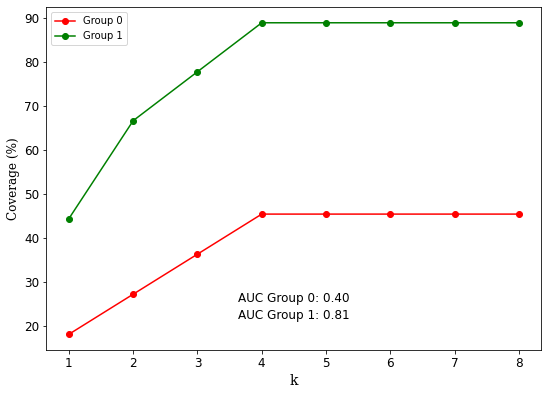

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import auc

saturation_point_g0 = 0
saturation_point_g1 = 0
coverage_till_now_g0 = 0
coverage_till_now_g1 = 0

group_coverages = {0.0: [], 1.0: []}
for k in results2:
    cov0 = results2[k][0.0]['Coverage'] 
    if cov0 > coverage_till_now_g0:
        coverage_till_now_g0 = cov0
        saturation_point_g0 = k
    
    cov1 = results2[k][1.0]['Coverage']
    if cov1 > coverage_till_now_g1:
        coverage_till_now_g1 = cov1
        saturation_point_g1 = k

    group_coverages[0.0].append(cov0)
    group_coverages[1.0].append(cov1)

print(f"Saturation point for group 0: {np.round(saturation_point_g0,2)}")
print(f"\nSaturation point for group 1: {np.round(saturation_point_g1,2)}")

group0_coverages = np.array(group_coverages[0.0])
group1_coverages = np.array(group_coverages[1.0])

x = list(np.arange(1, 9, 1))
max_auc = auc(x, [100]*len(x))

group0_coverages = np.array(group_coverages[0.0])
group1_coverages = np.array(group_coverages[1.0]) 

group0_coverages = np.round(auc(x, group0_coverages) / max_auc, 2)
group1_coverages = np.round(auc(x, group1_coverages) / max_auc, 2)


plt.plot(x, group_coverages[0.0], 'o-', color='red', label='Group 0')
plt.plot(x, group_coverages[1.0], 'o-', color='green', label='Group 1')
plt.text(0.5, 0.15, f'AUC Group 0: {group0_coverages:.2f}', horizontalalignment='center', verticalalignment='center',  fontsize=12,transform=plt.gca().transAxes)
plt.text(0.5, 0.1, f'AUC Group 1: {group1_coverages:.2f}', horizontalalignment='center', verticalalignment='center', fontsize=12, transform=plt.gca().transAxes)
plt.ylabel('Coverage (%)', fontsize=12, fontfamily='serif')
plt.xticks(x)
plt.xlabel('k', fontsize=14, fontfamily='serif')
plt.ylabel('Coverage (%)', fontsize=12, fontfamily='serif')
plt.tick_params(axis='both', labelsize=12)
plt.legend(loc='best')  
plt.tight_layout()
fig_size = (8, 6)
plt.gcf().set_size_inches(fig_size)
plt.savefig(f"{FGCE_DIR}{sep}tmp{sep}Student{sep}figs{sep}max_vector_distance_as_cost_function_stable_d.pdf")
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import auc

auc_matrix = {}
saturation_points = {}
for d in list([np.arange(0.1, 5.5, 0.5)])[0]:
    saturation_point_g0 = 1
    saturation_point_g1 = 1
    coverage_till_now_g0 = 0
    coverage_till_now_g1 = 0
    
    d = np.round(d, 2)
    auc_matrix[d] = {}
    results = {}
    for cfes in np.arange(1, 11, 1):
        results[cfes] = (filter_subdict(main_cost_constrained_GCFEs(epsilon=3, tp=0.6, td=0.001, datasetName='Student', group_identifier='sex',
                                skip_model_training=True, skip_gcfe_calculation=False, skip_graph_creation=True,
                                max_d = d, cost_function = "max_vector_distance", k=cfes, k_selection_method="greedy_accross_all_ccs")[0], allowed_subkeys))

    group_coverages = {0.0: [], 1.0: []}
    for cfes in results:
        cov0 = results[cfes][0.0]['Coverage'] 
        if cov0 > coverage_till_now_g0:
            coverage_till_now_g0 = cov0
            saturation_point_g0 = cfes
        
        cov1 = results[cfes][1.0]['Coverage']
        if cov1 > coverage_till_now_g1:
            coverage_till_now_g1 = cov1
            saturation_point_g1 = cfes

        group_coverages[0.0].append(cov0)
        group_coverages[1.0].append(cov1)

    saturation_points[d] = {0.0: saturation_point_g0, 1.0: saturation_point_g1}

    group0_coverages = np.array(group_coverages[0.0])
    group1_coverages = np.array(group_coverages[1.0])
    x = list(np.arange(1, 11, 1))
    max_auc = auc(x, [100]*len(x))

    group0_coverages = np.array(group_coverages[0.0])
    group1_coverages = np.array(group_coverages[1.0]) 

    group0_coverages = np.round(auc(x, group0_coverages) / max_auc, 2)
    group1_coverages = np.round(auc(x, group1_coverages) / max_auc, 2)

    auc_matrix[d] = {0.0: group0_coverages, 1.0: group1_coverages}

In [5]:
saturation_points

{0.1: {0.0: 1, 1.0: 1},
 0.6: {0.0: 1, 1.0: 1},
 1.1: {0.0: 1, 1.0: 1},
 1.6: {0.0: 1, 1.0: 1},
 2.1: {0.0: 1, 1.0: 2},
 2.6: {0.0: 5, 1.0: 4},
 3.1: {0.0: 6, 1.0: 2},
 3.6: {0.0: 3, 1.0: 1},
 4.1: {0.0: 2, 1.0: 1},
 4.6: {0.0: 2, 1.0: 1},
 5.1: {0.0: 2, 1.0: 1}}

In [6]:
auc_matrix

{0.1: {0.0: 0.0, 1.0: 0.0},
 0.6: {0.0: 0.0, 1.0: 0.0},
 1.1: {0.0: 0.0, 1.0: 0.0},
 1.6: {0.0: 0.0, 1.0: 0.11},
 2.1: {0.0: 0.09, 1.0: 0.22},
 2.6: {0.0: 0.37, 1.0: 0.5},
 3.1: {0.0: 0.67, 1.0: 0.88},
 3.6: {0.0: 0.95, 1.0: 0.89},
 4.1: {0.0: 0.99, 1.0: 1.0},
 4.6: {0.0: 0.99, 1.0: 1.0},
 5.1: {0.0: 0.99, 1.0: 1.0}}

# Testing for different Classifiers

In [ ]:
results = main_cost_constrained_GCFEs(epsilon=3, tp=0.6, td=0.001, datasetName='Student', group_identifier='sex',
                            skip_model_training=False, skip_graph_creation=False, skip_gcfe_calculation=False,
                            max_d = 5, cost_function = "max_vector_distance", k=2, k_selection_method="greedy_accross_all_ccs")[0]

In [ ]:
results = main_cost_constrained_GCFEs(epsilon=3, tp=0.6, td=0.001, datasetName='Student', group_identifier='sex',
                            skip_model_training=True, skip_graph_creation=True, skip_gcfe_calculation=False,
                            classifier='xgb', max_d = 3, cost_function = "max_vector_distance",  k=2, k_selection_method="greedy_accross_all_ccs")[0]

In [ ]:
results = main_cost_constrained_GCFEs(epsilon=3, tp=0.6, td=0.001, datasetName='Student', group_identifier='sex',
                            skip_model_training=True, skip_graph_creation=True, skip_gcfe_calculation=False,
                            classifier='dnn', max_d = 3, cost_function = "max_vector_distance", k=2, k_selection_method="greedy_accross_all_ccs")[0]

# Getting Graph Structure for selected e

In [17]:
import networkx as nx
import pickle


with open(f"{FGCE_DIR}{sep}tmp{sep}Student{sep}Graphs{sep}Graph_3.pkl", "rb") as file:
    graph = pickle.load(file)

strongly_connected_components = list(nx.strongly_connected_components(graph))
weakly_connected_components = list(nx.weakly_connected_components(graph))

print("Strongly connected components:", len(strongly_connected_components))
print("Weakly connected components:", len(weakly_connected_components))

with open(f"{FGCE_DIR}{sep}tmp{sep}Student{sep}cost_constrained_GCFEs{sep}results_Student_eps3_tp0.6_k_2_cost_function_max_vector_distance_d_5_kmethod_greedy_accross_all_ccs.json", "r") as file:
    results = json.load(file)    

Strongly connected components: 548
Weakly connected components: 3


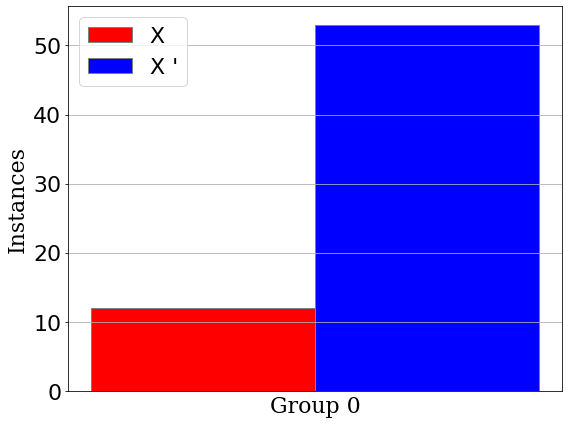

In [18]:
import matplotlib.pyplot as plt
bar_width = 50

fig, ax = plt.subplots(figsize=(12, 8))

stats = results['Graph Stats']['0.0']
aWCCs = set()
r0 = results['0.0']

for fn in r0:
    if fn in ['Coverage', 'Avg. distance', 'Avg. path cost', 'Median distance', 'Median path cost']:
        continue
    aWCCs.add(f"{r0[fn]['cfe_cc']}")

cc_names = [cc for cc in stats if cc.isdigit()]
num_cc = len(cc_names)

bar_width = 0.4
bar_gap = 0.5

center_poss = []
labels_added = {'positives': False, 'false_negatives': False}

for j, cc in enumerate(cc_names):
    if cc not in aWCCs:
        continue
    positives = stats[cc]['positives']
    false_negatives = stats[cc]['false_negatives']

    center_pos = j * (2 * bar_width + bar_gap)  
    r1 = center_pos - bar_width / 2  
    r2 = center_pos + bar_width / 2  

    if not labels_added['false_negatives']:
        ax.bar(r1, false_negatives, color='r', width=bar_width, edgecolor='grey', label='X')
        labels_added['false_negatives'] = True
    else:
        ax.bar(r1, false_negatives, color='r', width=bar_width, edgecolor='grey')

    if not labels_added['positives']:
        ax.bar(r2, positives, color='b', width=bar_width, edgecolor='grey', label="X '")
        labels_added['positives'] = True
    else:
        ax.bar(r2, positives, color='b', width=bar_width, edgecolor='grey')

    center_poss.append((r1 + r2) / 2)

ax.set_xticks([])

ax.tick_params(axis='x', labelsize=22)
ax.tick_params(axis='y', labelsize=22)

ax.set_xlabel(f'Group 0', fontsize=22, fontfamily='serif')
ax.set_ylabel('Instances', fontsize=22, fontfamily='serif')

ax.legend()
ax.grid(True)

ax.legend(fontsize=22)
fig_size = (8, 6)
plt.gcf().set_size_inches(fig_size)

plt.tight_layout()
plt.show()

fig.savefig(f"{FGCE_DIR}{sep}tmp{sep}Compas{sep}figs{sep}ccs_positives_false_negatives_g0.pdf")


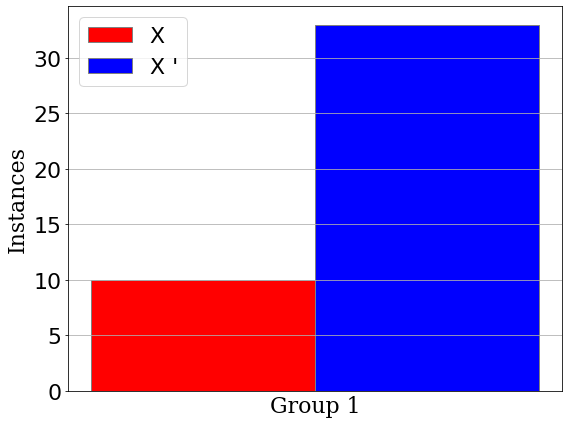

In [19]:
import matplotlib.pyplot as plt
bar_width = 50

fig, ax = plt.subplots(figsize=(12, 8))

stats = results['Graph Stats']['1.0']
aWCCs = set()
r0 = results['1.0']

for fn in r0:
    if fn in ['Coverage', 'Avg. distance', 'Avg. path cost', 'Median distance', 'Median path cost']:
        continue
    aWCCs.add(f"{r0[fn]['cfe_cc']}")

cc_names = [cc for cc in stats if cc.isdigit()]
num_cc = len(cc_names)

bar_width = 0.4
bar_gap = 0.5

center_poss = []
labels_added = {'positives': False, 'false_negatives': False}

for j, cc in enumerate(cc_names):
    if cc not in aWCCs:
        continue
    positives = stats[cc]['positives']
    false_negatives = stats[cc]['false_negatives']

    center_pos = j * (2 * bar_width + bar_gap)  
    r1 = center_pos - bar_width / 2  
    r2 = center_pos + bar_width / 2  

    if not labels_added['false_negatives']:
        ax.bar(r1, false_negatives, color='r', width=bar_width, edgecolor='grey', label='X')
        labels_added['false_negatives'] = True
    else:
        ax.bar(r1, false_negatives, color='r', width=bar_width, edgecolor='grey')

    if not labels_added['positives']:
        ax.bar(r2, positives, color='b', width=bar_width, edgecolor='grey', label="X '")
        labels_added['positives'] = True
    else:
        ax.bar(r2, positives, color='b', width=bar_width, edgecolor='grey')

    center_poss.append((r1 + r2) / 2)

ax.set_xticks([])

ax.tick_params(axis='x', labelsize=22)
ax.tick_params(axis='y', labelsize=22)

ax.set_xlabel(f'Group 1', fontsize=22, fontfamily='serif')
ax.set_ylabel('Instances', fontsize=22, fontfamily='serif')

ax.legend()
ax.grid(True)

ax.legend(fontsize=22)
fig_size = (8, 6)
plt.gcf().set_size_inches(fig_size)

plt.tight_layout()
plt.show()

fig.savefig(f"{FGCE_DIR}{sep}tmp{sep}Compas{sep}figs{sep}ccs_positives_false_negatives_g1.pdf")